In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


On importe notre Dataframe à traiter

In [4]:
import pandas as pd
df_bibliovid=pd.read_json('/content/drive/MyDrive/data/bibliovid.json')
df_bibliovid = df_bibliovid.dropna(subset=['abstract','topics'])
df_bibliovid = df_bibliovid.drop(df_bibliovid[ df_bibliovid.abstract==''].index)
df_bibliovid = df_bibliovid.drop(df_bibliovid[ df_bibliovid.topics==''].index)

On éxécute le traitement de base appliqué dans le notebook servant de "baseline", de sorte à manipuler des objets de même structure

In [5]:
def vectorize(label_list,dico):
    return [int(elt in label_list) for  elt in dico]

In [6]:
if True:
  spec_dict=dict()
  spec_list=[]
  for elt in df_bibliovid['specialties'].values:
      spec_list.append(elt[0]['name'])
  spec_set=set(spec_list)
  i=0
  for elt in spec_set:
    spec_dict[elt]=i
    i+=1
  print(spec_dict)
  df_bibliovid['vect_specs']=df_bibliovid.topics.apply(lambda x: vectorize(x,spec_dict))
  df_bibliovid['cat_text']=df_bibliovid['title']+df_bibliovid['abstract']
  df_bibliovid['len']=df_bibliovid['cat_text'].apply(lambda x: len(x.split(' ')))
  df_bibliovid['len_sentence']=df_bibliovid['cat_text'].apply(lambda x: len(x.split('.')))
  df_bibliovid=df_bibliovid.reset_index(drop=True)

{'Gériatrie': 0, 'Hépato-gastro-entérologie': 1, 'Neurologie': 2, 'Confinement/Déconfinement': 3, 'Anesthésie-Réanimation': 4, 'Hématologie': 5, 'Cardiologie et maladies métaboliques': 6, 'Psychiatrie': 7, 'Gynécologie Obstétrique': 8, 'Hygiène': 9, 'Transversale': 10, 'Pédiatrie': 11, 'Radiologie': 12, 'Néphrologie': 13, 'Immunité': 14, 'Infectiologie': 15, 'Virologie': 16}


Installation de Spacy et de Scispacy, ainsi que du modèle "en_core_sci_sm" utilisé

In [2]:
!pip install -U spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

     |████████████████████████████████| 10.4MB 5.4MB/s 
     |████████████████████████████████| 1.1MB 42.6MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 194kB 20.1MB/s 
  Using cached https://files.pythonhosted.org/packages/00/84/fc9dc13ee536ba5e6b8fd10ce368fea5b738fe394c3b296cde7c9b144a92/pybind11-2.6.1-py2.py3-none-any.whl
  Created wheel for nmslib: filename=nmslib-2.0.8-cp36-cp36m-linux_x86_64.whl size=9168392 sha256=fe2a21e5ab03f720df0dd7286255535ce5d458a068afdbad33a3db35451ae05c
  Stored in directory: /root/.cache/pip/wheels/e8/ac/90/494f2ecb0c10fe1ed32d9a64434576d04fae8fb4234097566b
Successfully built nmslib
     |████████████████████████████████

On charge le modèle que nous allons utiliser

In [11]:
import scispacy
import spacy

#Core models
import en_core_sci_sm
nlp = en_core_sci_sm.load()

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_sm' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Nous allons d'abord prendre en main l'outil petit à petit pour bien expliciter ce que nous faisons, on extrait donc d'abord dans une liste l'ensemble des textes concatenés

In [7]:
test = list(df_bibliovid['cat_text'])


In [9]:
print(test[0])

Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort StudyObesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 53

La méthode .ents va extraire du texte en entrée de cette méthode les mots importants, pertinents selon le modèle que nous avons employé (rappel: le modèle ici employé est "en_core_sci_sm", adapté au données biomédicales)

In [12]:
doc = nlp(test[0])
print(doc.ents)
print(len(test[0]))
print(len(doc.ents))

(Body Mass Index, Risk, Intubation, Death, SARS-CoV-2, Infection, Retrospective Cohort StudyObesity, risk factor, pneumonia, acute respiratory distress syndrome, obesity, associated with, intubation, death, inflammation, cardiac injury, fibrinolysis, coronavirus disease, COVID-19, Retrospective cohort study, community hospital, New York City, adults, hospitalized, laboratory-confirmed severe, acute respiratory syndrome coronavirus 2 infection, period, days, in-hospital observation, Body mass index, BMI, admission biomarkers, inflammation, C-reactive protein, CRP, level, erythrocyte, ESR, cardiac injury, troponin level, fibrinolysis, D-dimer level, primary end point, composite, intubation, death, time-to-event analysis, hospital length of stay, days, interquartile range, days, patients, died, hospitalized, Compared, overweight, patients, patients, obesity, higher, risk, intubation, death, highest, risk, class 3, obesity, hazard ratio, CI, association, patients, younger, years, older, pa

on crée une liste où l'élément d'indice i est le texte d'indice i de la conlonne 'cat_text' où ne sont gardés que les mots extraits par la méthode .ents

In [13]:
new_text = []
for i in range(len(test)):
  print(i)
  new_text.append(nlp(test[i]).ents)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
new_text2 = list(new_text)
new_text2[0]

(Body Mass Index,
 Risk,
 Intubation,
 Death,
 SARS-CoV-2,
 Infection,
 Retrospective Cohort StudyObesity,
 risk factor,
 pneumonia,
 acute respiratory distress syndrome,
 obesity,
 associated with,
 intubation,
 death,
 inflammation,
 cardiac injury,
 fibrinolysis,
 coronavirus disease,
 COVID-19,
 Retrospective cohort study,
 community hospital,
 New York City,
 adults,
 hospitalized,
 laboratory-confirmed severe,
 acute respiratory syndrome coronavirus 2 infection,
 period,
 days,
 in-hospital observation,
 Body mass index,
 BMI,
 admission biomarkers,
 inflammation,
 C-reactive protein,
 CRP,
 level,
 erythrocyte,
 ESR,
 cardiac injury,
 troponin level,
 fibrinolysis,
 D-dimer level,
 primary end point,
 composite,
 intubation,
 death,
 time-to-event analysis,
 hospital length of stay,
 days,
 interquartile range,
 days,
 patients,
 died,
 hospitalized,
 Compared,
 overweight,
 patients,
 patients,
 obesity,
 higher,
 risk,
 intubation,
 death,
 highest,
 risk,
 class 3,
 obesity,


On transforme les tuples en listes

In [15]:
len(new_text2)
for i in range(len(new_text2)):
  new_text2[i] = list(new_text2[i])




On remplace les mots qui sont des éléments de spacy par des strings

In [16]:
for i in range(len(new_text2[0])):
  new_text2[0][i] = str(new_text2[0][i])


On reforme les listes sous forme de texte

In [17]:
essai = " ".join(new_text2[0])

In [18]:
essai

'Body Mass Index Risk Intubation Death SARS-CoV-2 Infection Retrospective Cohort StudyObesity risk factor pneumonia acute respiratory distress syndrome obesity associated with intubation death inflammation cardiac injury fibrinolysis coronavirus disease COVID-19 Retrospective cohort study community hospital New York City adults hospitalized laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection period days in-hospital observation Body mass index BMI admission biomarkers inflammation C-reactive protein CRP level erythrocyte ESR cardiac injury troponin level fibrinolysis D-dimer level primary end point composite intubation death time-to-event analysis hospital length of stay days interquartile range days patients died hospitalized Compared overweight patients patients obesity higher risk intubation death highest risk class 3 obesity hazard ratio CI association patients younger years older patients Body mass index patients primary analyses imputation missing BMI Up

In [19]:
print(test[0])

Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort StudyObesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 53

In [20]:
for j in range(len(new_text2)):
  for i in range(len(new_text[j])):
    new_text2[j][i] = str(new_text2[j][i])
  new_text2[j] = " ".join(new_text2[j])

In [21]:
new_text2

['Body Mass Index Risk Intubation Death SARS-CoV-2 Infection Retrospective Cohort StudyObesity risk factor pneumonia acute respiratory distress syndrome obesity associated with intubation death inflammation cardiac injury fibrinolysis coronavirus disease COVID-19 Retrospective cohort study community hospital New York City adults hospitalized laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection period days in-hospital observation Body mass index BMI admission biomarkers inflammation C-reactive protein CRP level erythrocyte ESR cardiac injury troponin level fibrinolysis D-dimer level primary end point composite intubation death time-to-event analysis hospital length of stay days interquartile range days patients died hospitalized Compared overweight patients patients obesity higher risk intubation death highest risk class 3 obesity hazard ratio CI association patients younger years older patients Body mass index patients primary analyses imputation missing BMI U

On remplace les textes concaténés par les nouveaux textes obtenues

In [22]:
df_bibliovid['cat_text'] = new_text2

In [23]:
df_bibliovid

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Body Mass Index Risk Intubation Death SARS-CoV...,259,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",mRNA Vaccine SARS-CoV-2 Preliminary ReportThe ...,269,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Pathophysiology Transmission Diagnosis Treatme...,436,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS-C

Ici la longueur des textes concaténés avant le traitement par spacy 

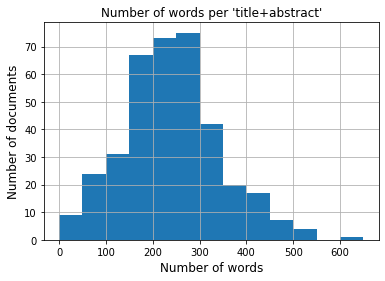

In [25]:
import numpy as np
import matplotlib.pyplot as plt
longueurs = df_bibliovid.len
longueurs.hist(bins = np.arange(0,700,50))
plt.title("Number of words per 'title+abstract'")
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

In [26]:
texts = list(df_bibliovid['cat_text'].apply(lambda x: len(x.split(' '))))
df_bibliovid['len'] = texts

Ici la longueur des textes concaténés après le traitement avec Spacy

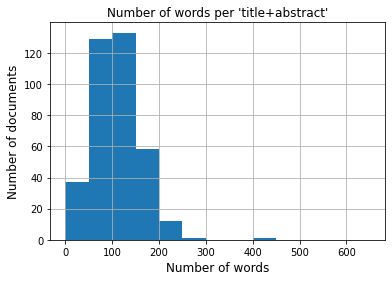

In [27]:
import matplotlib.pyplot as plt
longueurs = df_bibliovid.len
longueurs.hist(bins = np.arange(0,700,50))
plt.title("Number of words per 'title+abstract'")
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

In [28]:
df_bibliovid_augmented = df_bibliovid.copy()
df_bibliovid_augmented

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Body Mass Index Risk Intubation Death SARS-CoV...,148,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",mRNA Vaccine SARS-CoV-2 Preliminary ReportThe ...,116,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Pathophysiology Transmission Diagnosis Treatme...,209,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS-C

Le nouveau notebook obtenu peut ensuite remplacer celui utilisé dans le  notebook "baseline" sur le notebook "multilabel_specialities_from_bibliovid" et ainsi voir l'amélioration des résultats (décrits dans le rapport)